In [163]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

#### Using LSM method to price American Options:
Sample parameters:

In [164]:
# sample parameters (to be specifically selected in the future)
mu = 0.001
sig = 0.2

Simulating Geometric Brownian Motion using the following equation:
$$ S_t = S_0 e^{(\mu - \frac{1}{2} \sigma^2)t+\sigma W_t} $$

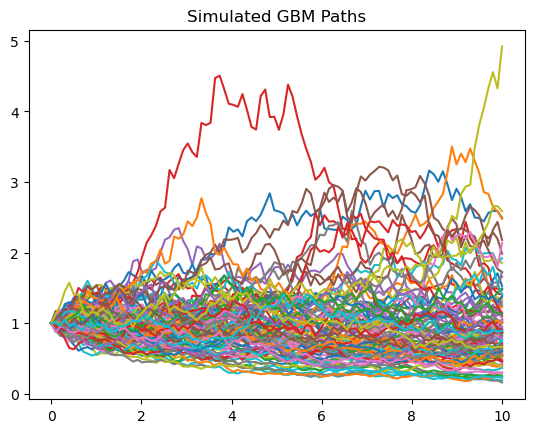

In [169]:
# number of paths
paths = 100

# number of steps
steps = 100

# total time and vector of intervals
time = 10
T = np.linspace(0, time, steps)
dt = time / (steps - 1)

# we simulate the paths given by the expontential
exp0 = np.zeros((paths, 1))  

# simulate random variables for the brownian motion
W = ss.norm.rvs(loc=(mu - 0.5 * sig**2) * dt, scale=np.sqrt(dt) * sig, size=(paths, steps - 1))

# add the original values of the exponential(zeros), and take the cumulative sum
# this is to make the GBM 'build' off of itself 
exponent = np.concatenate((exp0, W), axis=1).cumsum(1)

# exponential all paths to get the prices 
S_T = np.exp(exponent)

plt.plot(T, S_T.T)
plt.title("Simulated GBM Paths")
plt.show()

Option parameters:

In [170]:
# interest rate
r = 0.06  

# strike price
K = 0.9

# discount factor
df = np.exp(-r * dt)  

# option type
type = 'put'

Least-Squares Algorithm (as per https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf)

The conditional expectation regression is a polynomial regression of degree 2:
$$ E[Y|X] = \beta_0 + \beta_1 X + \beta_2 X^2 $$

This is to estimate the expected cash flow from continuing the option's life

In [171]:
# payoff function
if type == 'put':
    H = np.maximum(K - S_T, 0)  
elif type == 'call':
    H = np.maximum(K - S_T, 0)

# valuation matrix, following same shape as payoff function
V = np.zeros_like(H)  

# Last value column is same as payoff (forced to exercise or not)
V[:, -1] = H[:, -1]

# Valuation by LSM
for t in range(steps - 2, 0, -1):

    # only calculating conditional expectation for ITM option paths
    valid = H[:, t] > 0  
    
    # fit polynomial regression as stated above:
    # could use other packages such as sklearn, this works
    cond_expectation = np.polyfit(S_T[valid, t], V[valid, t + 1] * df, 2) 

    # evaluating the polynomial on all valid paths at time t
    expected_cash_flow = np.polyval(cond_expectation, S_T[valid, t]) 

    # vector of booleans where we will actually exercise the option
    early_exercise = np.zeros(paths, dtype=bool)  

    # payoff right now is greater than expected cash flow
    early_exercise[valid] = H[valid, t] > expected_cash_flow  

    # we set the valuation to the payoff when it is optimal to exercise
    # (early exercise, same as max function in binomial method)
    V[early_exercise, t] = H[early_exercise, t]  

    # if we exercise, the future cash flows should be zero:
    V[early_exercise, t + 1 :] = 0  

    # as for all the other paths, we discount:
    V[~early_exercise, t] = V[~early_exercise, t + 1] * df

# we discount all paths to time 0, and average them out for our final price
V0 = np.mean(V[:, 1] * df)  
print("LSM priced american option: ", V0)

LSM priced american option:  0.1386675445219643
